<a href="https://colab.research.google.com/github/matthew8sweeney/computer-counterpoint-2/blob/master/music_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
# for music analysis
import music21 as m21

# for fetching data from the internet
from bs4 import BeautifulSoup
from urllib.request import urlopen, urlretrieve
import time

# for displaying music notation
import os
from IPython.display import Image, Audio, clear_output

# for processing data
import numpy as np
from collections import Counter
from functools import lru_cache

# for models
import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import random
import math

# for training
import matplotlib.pyplot as plt
from copy import deepcopy

## Utility


In [2]:
# Set device to point to a GPU if we have one, CPU otherwise.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
# device = device_cpu  # move to cpu to get better error messages?
device

device(type='cuda', index=0)

In [3]:
class CellOrderError(Exception):
    """Raised when you need something from a later cell"""
    pass

### Music21 `.show()` Setup
Allows music21 methods for showing music notation to work properly in Colab environment.  
From a [notebook](https://colab.research.google.com/gist/mscuthbert/431dee45c01598a0c11bc27823bd1c5b/music21_setup.ipynb) by Michael Cuthbert, who also created music21.

In [4]:
!apt-get install musescore > /dev/null
!apt-get install xvfb > /dev/null
!sh -e /etc/init.d/x11-common start
os.putenv('DISPLAY', ':99.0')
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

us = m21.environment.UserSettings()
us["musescoreDirectPNGPath"] = "/usr/bin/mscore"
us["directoryScratch"] = "/tmp/"

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/x/xorg-server/xvfb_1.19.6-1ubuntu4.8_amd64.deb  404  Not Found [IP: 91.189.88.152 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?
 * Setting up X socket directories...
   ...done.
start-stop-daemon: unable to stat /usr/bin/Xvfb (No such file or directory)


### Functions for Playing Audio and Showing Notation.  
From a [notebook](https://colab.research.google.com/drive/17Fql7pyK3xsO8KmZorvb1tBoPomidCPB) by Robby Nevels.

In [5]:
!apt-get install lilypond > /dev/null
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

In [6]:
def show_lily(m21_music):
    """Liable to break if given music containing rests"""
    display(Image(str(m21_music.write('lily.png'))))

def play(m21_music):
    filename = m21_music.write('mid')
    !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
    display(Audio(filename + '.wav'))

In [7]:
# this one was by me
def show_example(m21_music):
    play(m21_music)
    m21_music.show()

## Fetch Data

### Script for fetching MIDI from Mutopia Project
From Isaiah Hull's Data Camp [article](https://www.datacamp.com/community/tutorials/using-tensorflow-to-compose-music).

In [8]:
def fetch_data_mutopia(n, style):
    """
    Download midi files from the Mutopia Project

    Args:
        n (int): kind of approximately the number of files to get
    
    Returns:
        list 
    """
    # Define URL components
    url = (
        "https://www.mutopiaproject.org/cgibin/make-table.cgi"
        "?startat={{startat}}&searchingfor=&Composer=&Instrument=&Style={style}"
        "&collection=&id=&solo=&recent=&timelength="
        "&timeunit=&lilyversion=&preview="
    ).format(style=style)

    scores = []
    songNumber = 0 # start at beginning of all matching songs
    linkCount = 10

    start = time.time()

    # Locate and download each MIDI file
    m21.environment.set('autoDownload', 'allow')
    while linkCount > 0 and len(scores) < n:
        html = urlopen(url.format(startat=songNumber))
        soup = BeautifulSoup(html.read())
        links = soup.find_all('a')
        linkCount = 0
        for link in links:
            href = link['href']
            if href.find('.mid') >= 0:
                print("piece", len(scores), href)
                linkCount += 1
                # download data and keep in `scores` list
                scores.append(m21.converter.parse(href))
        songNumber += 10
        time.sleep(2.0)
    print("got", len(scores), "scores from Mutopia Proj. in", time.time() - start, "seconds")
    return scores

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
def prepare(score, roman=True, figures=True, verbose=False):
    """
    Do some programatic analysis of music in the given music21 Stream

    Args:
        score (music21.stream.Stream): a musical piece to analyze.
        roman (Optional bool): whether to analyze by harmonic function or pitch.
            If True, each vertical chord is represented with a Roman numeral.
            If False, each vertical chaord is represented as a string of pitch names.
        figures (Optional bool): whether to include figures in Roman numeral representations
        verbose (Optional bool): whether to print extra info
    
    Return:
        Stream, list of string, list of string: Tuple of (new score, chords, durations)
        OR, if roman=False:
        Stream, list of list of string, list of string: Tuple of (new score, pitch lists, durations)
    """
    # transpose to key of C M / c m, like normalization
    if verbose:
        print("analyzing key")
    key = score.analyze("key")
    if verbose:
        print("transposing")
    offset = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    new_score = score.transpose(offset)

    # merge all voices, grouping notes that sound at the same time into chords
    if verbose:
        print("grouping chords")
    new_score = new_score.chordify()

    # seperate pitch & duration
    if verbose:
        print("making chord/duration lists")
    # prepend a start symbol to enable prediction of first token
    score_chords = ["start" if roman else ()]
    score_durations = [0]  # start symbol for durations is 0 because they will be floats
    repr_chord = repr_roman(figures) if roman else repr_pitches

    for element in new_score:
        if isinstance(element, m21.chord.Chord):
            score_chords.append(repr_chord(element))
            score_durations.append(element.duration.quarterLength)

    return new_score, score_chords, score_durations

def repr_pitches(chord):
    # return " ".join(str(pitch) for pitch in chord.pitches)
    return [str(p) for p in chord.pitches]

def repr_roman(figures: bool):
    k = m21.key.Key("C")
    if figures:
        @lru_cache(maxsize=1000)
        def _repr_roman(chord):
            return m21.roman.romanNumeralFromChord(chord, k).figure
    else:
        def _repr_roman(chord):
            pass
            # return m21.roman.romanNumeralFromChord(chord).
    return _repr_roman


def get_mappings(elements_by_score):
    """
    Establish mappings between human-readable and numerical forms

    Args:
        elements_by_score (list of list): List where each element represents a piece of music.
            The elements of each sublist represent chords or durations
    
    Returns:
        dict, dict: tuple of (ele_to_num, num_to_ele) where
            ele_to_num maps human-readable representations to their numerical forms and
            num_to_ele maps from numerical forms to human-readable
    """
    # filter to unique chords/durations
    unique_elements = np.unique([e for score in elements_by_score for e in score])

    # create mappings between chord/duration and int
    element_to_ix = {e: i for i, e in enumerate(unique_elements)}
    ix_to_element = {i: e for e, i in element_to_ix.items()}

    return element_to_ix, ix_to_element
    
def get_mappings_pitch(pitch_lists_by_score):
    # filter to unique chords/durations
    unique_elements = np.unique([p for score in pitch_lists_by_score for c in score for p in c])
    # print(unique_elements)

    # create mappings between chord/duration and int
    element_to_ix = {e: i for i, e in enumerate(unique_elements)}
    ix_to_element = {i: e for e, i in element_to_ix.items()}

    return element_to_ix, ix_to_element


def to_numeric(elements_by_score, element_to_num):
    """
    Convert human-readable data to numerical form

    Args:
        elements_by_score (list of list): List where each element represents a piece of music.
            The elements of each sublist represent chords or durations
        element_to_num (dict of {str: int}): Mapping to use for conversion
    
    Returns:
        list of torch.tensor: Each element, a tensor, represents a single score of music
    """
    nums_by_score = [None] * len(elements_by_score)

    for i, score in enumerate(elements_by_score):
        score_elements = [None] * len(score)
        for j, element in enumerate(score):
            element_num = element_to_num[element]
            score_elements[j] = element_num
        nums_by_score[i] = score_elements

    return [torch.tensor(s) for s in nums_by_score]

def to_numeric_pitch(elements_by_score, pitch_to_num):
    nums_by_score = [None] * len(elements_by_score)

    # convert to numeric form
    for i, score in enumerate(elements_by_score):
        score_elements = [None] * len(score)
        for j, element in enumerate(score):
            element_pitches = [None] * len(element)
            for k, pitch in enumerate(element):
                pitch_num = pitch_to_num[pitch]
                element_pitches[k] = pitch_num
            score_elements[j] = element_pitches
        nums_by_score[i] = score_elements
    
    # convert to many-hot encoding
    score_tensors = []
    for score in nums_by_score:
        chord_tensors = []
        for chord in score:
            chord_tensor = torch.zeros((1, len(pitch_to_num)))
            for pitch in chord:
                chord_tensor[0, pitch] = 1
            chord_tensors.append(chord_tensor)
        score_tensors.append(torch.cat(chord_tensors, dim=0))

    return score_tensors


# adapted from cs370 assgmt 6
class ScoreDataset(Dataset):
    def __init__(self, scores, seqlen):
        """
        Create a ScoreDataset where Xs are sequences of `seqlen` tokens and Ys are the next token

        Args:
            scores (list of torch.tensor): List where each element is a 1-d tensor of chord tokens.
                Each tensor represents a single piece of music
            seqlen (int): Desired size for input sequences. Cannot be longer than any score.
        """
        self.check_score_data(scores)  # apply assertions

        self._scores = scores
        """list: tensors, each representing a piece of music"""

        self._score_lens = [s.shape[0] - seqlen for s in scores]
        """list: the number of samples in each corresponding score"""

        self._seqlen = seqlen
        """int: the number of tokens in each sample's input sequence"""
    
    @lru_cache(maxsize=1)
    def __len__(self):
        """Returns the number of samples in the dataset"""
        return sum(self._score_lens)

    def __getitem__(self, sample_idx):
        """Returns a single sample from the dataset"""
        # figure out which score has the sample is in, and which chord to start at
        score_idx, chord_idx = self._get_internal_idxs(sample_idx)

        # X = a sequence of characters starting at the given index
        # take the requested number of consecutive tokens from the right score
        seq = self._scores[score_idx][chord_idx : chord_idx + self._seqlen]

        # Y = the next character after that sequence
        next = self._scores[score_idx][chord_idx + self._seqlen]

        return seq, next

    def check_score_data(self, scores):
        """
        Apply assertions to ensure that the given data is in the right form

        Args:
            scores (list of torch.tensor): the data to check
        
        Raises:
            AssertionError: chord data is not in the right form
        """
        pass  # maybe later

    @lru_cache(maxsize=None)
    def _get_internal_idxs(self, sample_idx):
        """
        This dataset may include multiple scores, so figure out 
            where the data for `self[sample_idx]` even is
        
        Args:
            sample_idx (int): index of the sample being accessed

        Raises:
            IndexError: index is out of bounds
        
        Returns:
            int, int: tuple of (score_idx, chord_idx) where
                score_idx is index of the right score in `self._scores` and
                chord_idx is the index of a chord within that score
        """
        total_len = 0
        for score_idx, score_len in enumerate(self._score_lens):
            # add the length of each score until total length includes sample idx
            total_len += score_len
            if total_len > sample_idx:
                # calculate the index of the sample's starting chord within the score
                chord_idx = sample_idx - total_len + self._score_lens[score_idx]
                return score_idx, chord_idx
        raise IndexError(f"Index {sample_idx} out of bounds")

In [11]:
# check if data is already ready
DATA_SAVE_PATH = "/content/drive/MyDrive/Computer Science/Deep Learning/"
try:
    # to force a reload of data
    # raise Exception("Forcing reload of data")

    start_time = time.time()
    # use pre-downloaded data
    chord_to_num = torch.load(DATA_SAVE_PATH+"chord_to_num.pt")
    num_to_chord = {n: c for c, n in chord_to_num.items()}

    dur_to_num = torch.load(DATA_SAVE_PATH+"dur_to_num.pt")
    num_to_dur = {n: d for d, n in dur_to_num.items()}

    pitch_to_num = torch.load(DATA_SAVE_PATH+"pitch_to_num.pt")
    num_to_pitch = {n: p for p, n in pitch_to_num.items()}

    # num_scores[i][:, 0] has chords
    # num_scores[i][:, 1] has durations
    num_chords_by_score = torch.load(DATA_SAVE_PATH+"num_chords_by_score.pt")
    num_scores = torch.load(DATA_SAVE_PATH+"num_scores.pt")
    num_scores_pitch = torch.load(DATA_SAVE_PATH+"num_scores_pitch.pt")

    # configure DataLoader
    dataset = ScoreDataset(num_chords_by_score, 24)
    dl = DataLoader(dataset, batch_size=1024, shuffle=True)

    # both chord and duration
    dataset_cd = ScoreDataset(num_scores, 24)
    dl_cd = DataLoader(dataset_cd, batch_size=1024, shuffle=True)

    # for pitch model
    dataset_p = ScoreDataset(num_scores_pitch, 24)
    dl_p = DataLoader(dataset_p, batch_size=1024, shuffle=True)

    print("Loaded pre-prepared data from Google Drive in", time.time() - start_time, "seconds")
    DATA_SAVED = True

except CellOrderError as e:
    print(e)
except Exception as e:
    print(e)
    # download from mutopia
    DATA_SAVED = False
    scores = fetch_data_mutopia(5, "Baroque")


Loaded pre-prepared data from Google Drive in 0.049729108810424805 seconds


In [12]:
# Inspect data
# if saved tensor is found, scores are not downloaded
if not DATA_SAVED:
    print("no. of scores:", len(scores))
    # show_example(scores[0])

## Prepare Data for Model

The cell below can take a very long time, about 1 hour for 400 songs in data
depending on prepare()

In [13]:
if not DATA_SAVED:
    start = time.time()

    new_scores = [None] * len(scores)
    chords_by_score = [None] * len(scores)
    durs_by_score = [None] * len(scores)
    pitch_lists_by_score = [None] * len(scores)

    # get lists of each sonority and its duration
    for i, score in enumerate(scores):
        print("starting analysis of score", i)
        new_score, chords, durs = prepare(score, verbose=False)
        new_score, pitch_lists, durs = prepare(score, verbose=False, roman=False)
        new_scores[i] = new_score
        chords_by_score[i] = chords
        pitch_lists_by_score[i] = pitch_lists
        durs_by_score[i] = durs

    print("analysis took", time.time() - start, "seconds total")

In [14]:
if not DATA_SAVED:
    start = time.time()

    # get mappings between sonority/duration and int
    chord_to_num, num_to_chord = get_mappings(chords_by_score)
    dur_to_num, num_to_dur = get_mappings(durs_by_score)
    pitch_to_num, num_to_pitch = get_mappings_pitch(pitch_lists_by_score)

    # get chords/durations represented numerically
    # would be one-hot, but pytorch embeddings need whatever index is 1, not all the 0s
    num_chords_by_score = to_numeric(chords_by_score, chord_to_num)
    num_durs_by_score = to_numeric(durs_by_score, dur_to_num)
    num_pitches_by_score = to_numeric_pitch(pitch_lists_by_score, pitch_to_num)
    
    num_scores = [torch.cat((c[:, None], d[:, None]), dim=1) for c, d in zip(num_chords_by_score, num_durs_by_score)]
    num_scores_pitch = [torch.cat((p, d[:, None]), dim=1) for p, d in zip(num_pitches_by_score, num_durs_by_score)]

    # configure DataLoader
    dataset = ScoreDataset(num_chords_by_score, 24)  # input sequence length `seqlen` is set here
    dl = DataLoader(dataset, batch_size=1024, shuffle=True)

    dataset_cd = ScoreDataset(num_scores, 24)  # input sequence length `seqlen` is set here
    dl_cd = DataLoader(dataset_cd, batch_size=1024, shuffle=True)
    
    # for pitch model
    dataset_p = ScoreDataset(num_scores_pitch, 24)
    dl_p = DataLoader(dataset_p, batch_size=1024, shuffle=True)

    print("formatting took", time.time() - start, "seconds")

    # save data to maybe make next time faster
    torch.save(num_chords_by_score, DATA_SAVE_PATH+"num_chords_by_score.pt")
    torch.save(num_scores, DATA_SAVE_PATH+"num_scores.pt")
    torch.save(num_scores_pitch, DATA_SAVE_PATH+"num_scores_pitch.pt")
    torch.save(chord_to_num, DATA_SAVE_PATH+"chord_to_num.pt")
    torch.save(dur_to_num, DATA_SAVE_PATH+"dur_to_num.pt")
    torch.save(pitch_to_num, DATA_SAVE_PATH+"pitch_to_num.pt")
    DATA_SAVED = True

In [15]:
print(chord_to_num)
print("chord vocabulary size:", len(chord_to_num))
print(dur_to_num)
print("duration vocabulary size:", len(dur_to_num))
print(pitch_to_num)
print("pitch vocabulary size:", len(pitch_to_num))
print("no. chord/dur training samples:", len(dataset_cd))
print("no. pitch training samples:", len(dataset_p))

{'#i4': 0, '#i4bb3': 1, '#i6': 2, '#i7b2': 3, '#ib3': 4, '#ib7': 5, '#ibb7b3': 6, '#io4': 7, '#io5b3': 8, '#io6': 9, '#io7b4': 10, '#io7b4b2': 11, '#iob5': 12, '#iob64': 13, '#iob64bb3': 14, '#iv/o4b3': 15, '#iv/o7': 16, '#iv/ob64b3': 17, '#iv/ob6b42': 18, '#iv/ob7b5': 19, '#iv2': 20, '#iv6': 21, '#iv64': 22, '#iv6b5': 23, '#iv6bb53': 24, '#iv6bb5b2': 25, '#iv7b2': 26, '#ivb3': 27, '#ivb3b2': 28, '#ivb42': 29, '#ivb4b32': 30, '#ivb5b42': 31, '#ivb7': 32, '#ivb75b4': 33, '#ivb75bb4': 34, '#ivb76b5': 35, '#ivb7b3': 36, '#ivb7b3b2': 37, '#ivbb7b3': 38, '#ivo4': 39, '#ivo4bb3': 40, '#ivo5b3': 41, '#ivo6': 42, '#ivo63b3': 43, '#ivo6b3b2': 44, '#ivo7': 45, '#ivo7b4b2': 46, '#ivob5': 47, '#ivob5b3b2': 48, '#ivob64': 49, '#ivob64bb3': 50, '#ivob6b42': 51, '#ivob75b2': 52, '#ivob76b3': 53, '#ivobb7b5': 54, '#v': 55, '#v/o7': 56, '#v2': 57, '#v6': 58, '#v6b5': 59, '#vb42': 60, '#vb7': 61, '#vb7b3': 62, '#vb7bb3': 63, '#vbb3': 64, '#vo4': 65, '#vo4b3': 66, '#vo5b3': 67, '#vo6': 68, '#vo63b3': 69,

## Define Models

In [169]:
class Basic_LSTM(torch.nn.Module):
    def __init__(self, input_size, lstm_hidden_size, lstm_layers, bi=True, output_size=None):
        """
        A basic LSTM with a softmax dense layer for output

        Args:
            input_size (int): The number of input features (probably from embedding)
            lstm_hidden_size (int): The number of hidden units in each lstm layer
            lstm_layers (int): The number of lstm layers to stack
            bi (Optional bool): Whether the lstm should be bidirectional
            output_size (Optional int): The number of output features.
                This is the same as the number of input features if output_size is None
        """
        super(Basic_LSTM, self).__init__()
        self.lstm_layers = lstm_layers
        self.bi = bi

        self.rec = torch.nn.LSTM(input_size, lstm_hidden_size, lstm_layers, bidirectional=bi, batch_first=True)
        self.fc = torch.nn.Linear(lstm_hidden_size * (1+bi), output_size or input_size)

    def forward(self, x, hc_old=None):
        """
        Args:
            x (torch.tensor): Input with shape (batch_size, seqlen, input_size)
            hc_old (tensor, tensor): Optional, old hidden-state/cell-state from last prediction
        """
        if hc_old is None:
            hc_old = self.__init_hidden_and_cell_state(x.shape[0])

        x, hc_out = self.rec(x, hc_old)
        x = self.fc(x)
        # x = F.softmax(self.fc(x), dim=2)  # do I apply softmax here?
        
        return x, hc_out
    
    def __init_hidden_and_cell_state(self, batch_size):
        # Uses __ 'name mangling' becaue who knows what names PyTorch already uses

        # create a 0-initialized hidden/cell state tuple for RNN to start a new sequence
        hc = (
            # shape is, like, (no. directions*no. layers, batch_size, hidden_size)
            torch.zeros(((1+self.bi)*self.lstm_layers, batch_size, self.rec.hidden_size)).to(device),
            torch.zeros(((1+self.bi)*self.lstm_layers, batch_size, self.rec.hidden_size)).to(device)
        )
        return hc
    
    @property
    def has_embedding(self):
        return False


class Embedding_LSTM(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_hidden_size, lstm_layers, bi=True):
        """
        The same basic LSTM, except with an input embedding layer

        Args:
            vocab_size (int): The number of different classes input tokens can be
            embed_size (int): The length of embedding vectors
            lstm_hidden_size (int): The number of hidden units in each lstm layer
            lstm_layers (int): The number of lstm layers to stack
            bi (Optional bool): Whether the lstm should be bidirectional
        """
        super(Embedding_LSTM, self).__init__()

        # use an embedding to better understand chord realationships
        self.embed = torch.nn.Embedding(vocab_size, embed_size)

        # use the basic LSTM I already defined
        self.basic_lstm = Basic_LSTM(embed_size, lstm_hidden_size, lstm_layers, bi=bi, output_size=vocab_size)
    
    def forward(self, x, hc_old=None):
        """
        Args:
            x (torch.tensor): Input with shape (batch_size, seqlen)
            hc_old (tensor, tensor): Optional, old hidden-state/cell-state from last prediction
        """
        x = self.embed(x)
        x, hc_out = self.basic_lstm(x, hc_old)
        
        return x, hc_out
    
    def sample_next(self, prev_chord, hc, temperature):
        """
        Sample a prediction from this model according to predicted likelihood and temperature

        Args:
            prev_chord (str): The model's most recent predicted chord
            hc (torch.tensor, torch.tensor): tuple of (hidden, cell)
            temperature (float): degree to which to disregard model's predicted likelihood
        Returns:
            str, (torch.tensor, torch.tensor): tuple of (chord, (hidden, cell))
        """
        if prev_chord is None:
            prev_chord = chord_to_num["start"]
        else:
            prev_chord = chord_to_num[prev_chord]
        prev_chord = torch.tensor([prev_chord]).to(device)
        # print("prev_chord shape from EmbLSTM Model sampling", prev_chord.shape)

        pred, hc = self(prev_chord[None, :], hc)
        softmax = F.softmax(pred[0,0] / temperature, dim=0)
        sampled = torch.multinomial(softmax, num_samples=1)
        next = num_to_chord[sampled.item()]

        return next, hc

    def generate(self, length, temperature, start="start"):
        score = m21.stream.Stream()
        kc = m21.key.Key("C")
        if start != "start":
            score.append(m21.roman.RomanNumeral(start, kc))

        # Stores the hidden/cell values to pass from one step to the next.  Initially None.
        hc = None
        # The most recent prediction
        current = start

        with torch.no_grad():
            for i in range(length):
                # Using the previous character and previous hidden/cell values,
                # sample the model (with the given temperature) to generate the next character.
                current, hc = self.sample_next(current, hc, temperature)
                score.append(m21.roman.RomanNumeral(current, kc))

        return score
    
    @property
    def has_embedding(self):
        return True

    @property
    def is_fancy(self):
        return False


class AugmentedLSTM(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, h=None):
        # go over pitches in a chord with LSTM, then cat result w/ chord/dur and send into another LSTM
        pass
    
    def init_h(self, batch_size):
        h = (
            torch.zeros(),
            torch.zeros()
        )
        return h


#TODO WIP
class ModelWrapper(torch.nn.Module):
    def __init__(self, n_criteria):
        """
        Real models can inherit from this class to get methods for sampling/training maybe

        Args:
            n_criteria (int): Number of different criteria used to calculate loss
        """
        super().__init__()
        self._n_criteria = n_criteria
    
    @property
    def n_criteria(self):
        return self._n_criteria

    # torch.nn.Module.train() is already a thing, but not what I want
    def _train(self, dataloader, epochs, lr=0.001, verbose=False, track_loss=True, losses=[]):
        """
        Train the model on given data for a given number of epochs

        Args:
            dataloader (torch.utils.data.DataLoader): Training data
            epochs (int): Number of epochs to train for
            lr (float): Learning rate to train with
            verbose (Optional bool): Whether to print shape/dtype info
            track_loss (Optional bool): Whether to maintain a list of loss values
            losses (Optional list): List to append loss values to
        """
        # make sure model is on the gpu (or appropriate device)
        self.to(device)

        # set up loss function and optimization algorithm
        loss_pitch = torch.nn.BCELoss()
        loss_dur = torch.nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, betas=(0.9, 0.999))

        # set up stat recording
        stats = StatReporter()
        stats.start()

        for epoch in range(epochs):
            for i, data in enumerate(dataloader):
                # send data to gpu
                inputs, labels = data[0].to(device), data[1].to(device)
                if verbose:
                    print("inputs shape:", inputs.shape)
                    print("inputs dtype:", inputs.dtype)
                    print("labels shape:", labels.shape)
                    print("labels dtype:", labels.dtype)

                # zero out the gradients
                optimizer.zero_grad()

                # apply forward propagation
                outputs, _h = self(inputs)
                
                # disregard outputs except for the last sequence element
                predictions = [out[:, -1, :] for out in outputs]
                # calculate loss
                # loss = sum(loss_func(p, labels[:, i]) for i, p in enumerate(predictions))
                loss = 0
                for i in range(len(predictions) - 1):
                    if verbose:
                        print(predictions[i])
                        print(labels[:, i])
                    loss += loss_pitch(torch.squeeze(predictions[i], dim=1), labels[:, i])
                loss += loss_dur(predictions[-1], labels[:, -1].long())

                loss.backward()

                # update self parameters
                optimizer.step()

                # show a cost/loss over iteration graph
                if track_loss:
                    losses.append(float(loss))

                # record stats for this iteration
                stats.iteration(epoch, i, loss)

        # end stat recording
        stats.end()


class Basic_GRU(torch.nn.Module):
    def __init__(self, input_size, lstm_hidden_size, lstm_layers, bi=True, output_size=None):
        super().__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers
        self.bi = bi

        self.lstm = torch.nn.LSTM(input_size, lstm_hidden_size, lstm_layers, bidirectional=bi)
        self.fc_out = torch.nn.Linear(lstm_hidden_size * (1+bi), output_size or input_size)

    def forward(self, x, lens, hc_old=None):
        """
        Args:
            x has shape (batch_size, seqlen, input_size)
            hc_old (tensor, tensor): optional, old hidden/cell state tuple from last time step
        """
        if hc_old is None:
            hc_old = self.__init_hidden_and_cell_state(x.shape[0])

        # "pack" variable-len sequences to avoid using autograd on padding values
        x_pack = pack_padded_sequence(x, lens, batch_first=True, enforce_sorted=True)
        lstm_out_pack, hc = self.lstm(x_pack, hc_old)
        lstm_out, _lens = pad_packed_sequence(lstm_out_pack, batch_first=True)

        out = F.softmax(self.fc_out(lstm_out), dim=2)
        
        return out, hc
    
    def __init_hidden_and_cell_state(self, batch_size):
        # create a 0-initialized cell tuple for RNN to start a new sequence
        return torch.zeros(((1+self.bi)*self.lstm_layers, batch_size, self.lstm_hidden_size)).to(device)
    
    @property
    def has_embedding(self):
        return False


class MultiCriterionModel(torch.nn.Module):
    def __init__(self, vocab_sizes, embed_sizes, hidden_size, bi=False):
        """
        A model that has chord and duration data in its inputs and outputs

        Args:
            vocab_sizes (tuple of int): The number of (chord, duration) classes
            embed_sizes (tuple of int): The size of (chord, duration) embeddings
            hidden_size (int): number of neurons per hidden layer
        """
        super().__init__()
        self.bi = bi

        self.embed_chord = torch.nn.Embedding(vocab_sizes[0], embed_sizes[0])
        self.embed_dur = torch.nn.Embedding(vocab_sizes[1], embed_sizes[1])

        self.seq_model = torch.nn.LSTM(sum(embed_sizes), hidden_size, batch_first=True, bidirectional=bi)

        self.fc_chord = torch.nn.Linear(hidden_size*(1+bi), vocab_sizes[0])
        self.fc_dur = torch.nn.Linear(hidden_size*(1+bi), vocab_sizes[1])
    
    def forward(self, x, h_old=None):
        """
        Args:
            x (torch.tensor): Input data of shape (batch_size, seq_len, input_dim)
            h_old (torch.tensor): Output from the model's last prediciton, like hidden state
        """
        if h_old is None:
            h_old = self.__init_h(x.shape[0])

        # split x into each input dimension (batch_size, seq_len)
        x_chord, x_dur = torch.split(x, 1, dim=2)
        x_chord = torch.squeeze(x_chord, dim=2)
        x_dur = torch.squeeze(x_dur, dim=2)

        # get embedding vectors (batch_size, seq_len, embed_size)
        x_chord = self.embed_chord(x_chord)
        x_dur = self.embed_dur(x_dur)

        # combine inputs back together and send into sequence model (batch_size, seq_len, lstm_hidden*2)
        x = torch.cat((x_chord, x_dur), dim=2)
        x, h = self.seq_model(x, h_old)

        # map to seperate predictions for each input dimension (batch_size, seq_len, vocab_size)
        x_chord = self.fc_chord(x)
        x_dur = self.fc_dur(x)

        return (x_chord, x_dur), h

    def __init_h(self, batch_size):
        # create a 0-initialized hidden/cell state tuple for RNN to start a new sequence
        h = (
            # shape is, like, (no. directions*no. layers, batch_size, hidden_size)
            torch.zeros(((1+self.bi), batch_size, self.seq_model.hidden_size)).to(device),
            torch.zeros(((1+self.bi), batch_size, self.seq_model.hidden_size)).to(device)
        )
        return h
    
    def sample_next(self, prev_chord, prev_dur, hc, temperature, verbose=False):
        """
        Sample a prediction from this model according to predicted likelihood and temperature

        Args:
            prev_chord (str): The model's most recent predicted chord, human-readable form
            prev_dur (str): The model's most recent predicted dur, human-readable form
            hc (torch.tensor, torch.tensor): tuple of (hidden, cell)
            temperature (float, float): degree to which to disregard model's predicted likelihood
        Returns:
            (str, str), (torch.tensor, torch.tensor): tuple of ((chord, duration), (hidden, cell))
        """
        # convet to numeric form for the model
        if prev_chord is None and prev_dur is None:
            prev_chord = chord_to_num["start"]
            prev_dur = dur_to_num[0]
        else:
            prev_chord = chord_to_num[prev_chord]
            prev_dur = dur_to_num[prev_dur]
        prev_chord = torch.tensor([prev_chord])[:, None].to(device)
        prev_dur = torch.tensor([prev_dur])[:, None].to(device)
        prev = torch.cat((prev_chord, prev_dur), dim=1)

        # apply model, adding mini-batch dimension to input
        (pred_chord, pred_dur), hc = self(prev[None, ...], hc)

        # choose 1 possible chord, 1 duration
        if verbose:
            print("pred_chord shape", pred_chord.shape)
            print("pred_chord", pred_chord)
            print("pred_dur shape", pred_dur.shape)
            print("pred_dur", pred_dur)
        sm_chord = F.softmax(pred_chord[0,0] / temperature[0], dim=0)
        sampled_chord = torch.multinomial(sm_chord, num_samples=1).item()

        sm_dur = F.softmax(pred_dur[0,0] / temperature[1], dim=0)
        sampled_dur = torch.multinomial(sm_dur, num_samples=1).item()
        if verbose:
            print("sample chord", sampled_chord)
            print("sample dur", sampled_dur)

        # convert back from numeric form
        next_chord = num_to_chord[sampled_chord]
        next_dur = num_to_dur[sampled_dur]

        return (next_chord, next_dur), hc

    def generate(self, length, temperature, start=("start", 0)):
        # add a specific tempo?
        mm = m21.tempo.MetronomeMark(number=80)
        score = m21.stream.Stream()
        score.append(mm)
        kc = m21.key.Key("C")

        # if starting with a specific chord, add that to the score first
        if start != ("start", 0):
            c = m21.roman.RomanNumeral(start[0], kc)
            c.quarterLength = start[1]
            score.append(c)

        # Stores the hidden/cell values to pass from one step to the next.  Initially None.
        hc = None
        # The most recent prediction
        cur_chord, cur_dur = start

        with torch.no_grad():
            for i in range(length):
                # Using the previous character and previous hidden/cell values,
                # sample the model (with the given temperature) to generate the next character.
                (cur_chord, cur_dur), hc = self.sample_next(cur_chord, cur_dur, hc, temperature)

                # add the predicted music to the score
                c = m21.roman.RomanNumeral(cur_chord, kc)
                c.quarterLength = cur_dur
                score.append(c)

        return score
    
    @property
    def multi_criterion(self):
        return 2  # number of different criteria used in calculating loss


# Source: https://pytorch.org/tutorials/beginner/transformer_tutorial
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
    
class TransformerModel(torch.nn.Module):
    def __init__(self, vocab_sizes, embed_sizes, n_enc, n_dec, ff):
        super().__init__()
        self.d_trans = sum(embed_sizes)

        self.embed_chord = torch.nn.Embedding(vocab_sizes[0], embed_sizes[0])
        self.embed_dur = torch.nn.Embedding(vocab_sizes[1], embed_sizes[1])
        # self.embed_out_chord = torch.nn.Embedding(vocab_sizes[0], embed_sizes[0])
        # self.embed_out_dur = torch.nn.Embedding(vocab_sizes[1], embed_sizes[1])

        self.pos_enc = PositionalEncoding(self.d_trans)
        
        # self.transformer = torch.nn.Transformer(self.d_trans, dim_feedforward=ff, 
        #     num_encoder_layers=n_enc, num_decoder_layers=n_dec)
        enc_layer = torch.nn.TransformerEncoderLayer(self.d_trans, 16, dim_feedforward=ff)
        self.transformer_enc = torch.nn.TransformerEncoder(enc_layer, n_enc)

        self.fc_chord = torch.nn.Linear(self.d_trans, vocab_sizes[0])
        self.fc_dur = torch.nn.Linear(self.d_trans, vocab_sizes[1])

    def forward(self, src, tgt=None):
        # reshape input to expected shape
        src = src.permute(1, 0, 2)
        # create mask for attention mechanism
        src_mask = model.generate_square_subsequent_mask(src.size(0)).to(device)
        # init target data if there is none
        # if tgt is None:
        #     s = src.size()
        #     chord_size = (s[0], s[1], s[2] - 1)
        #     dur_size   = (s[0], s[1], 1)
        #     tgt = (torch.zeros(chord_size).long().to(device), torch.zeros(dur_size).long().to(device))

        # seperate chord/duration for different embeddings
        src_chord, src_dur = torch.split(src, 1, dim=2)
        src_chord = torch.squeeze(src_chord, dim=2)
        src_dur = torch.squeeze(src_dur, dim=2)

        # tgt_chord, tgt_dur = tgt
        # tgt_chord = torch.squeeze(tgt_chord, dim=2)
        # tgt_dur = torch.squeeze(tgt_dur, dim=2)

        # get embedding vectors (batch_size, seq_len, embed_size)
        src_chord = self.embed_chord(src_chord)
        src_dur = self.embed_dur(src_dur)
        # tgt_chord = self.embed_out_chord(tgt_chord)
        # tgt_dur = self.embed_out_dur(tgt_dur)

        # cat for pos-ensoding and trnsformer
        src = torch.cat((src_chord, src_dur), dim=2)
        # tgt = torch.cat((tgt_chord, tgt_dur), dim=2)

        # apply positional encoding
        src = self.pos_enc(src * math.sqrt(self.d_trans))
        # tgt = self.pos_enc(tgt * math.sqrt(self.d_trans))

        # send through transformer
        # out = self.transformer(src, tgt)
        out = self.transformer_enc(src, src_mask)

        # send through fc layers
        out_chord = self.fc_chord(out)
        out_dur = self.fc_dur(out)

        # return in similar format to the lstm models for code reusability
        return (out_chord.permute(1, 0, 2), out_dur.permute(1, 0, 2)), None
        
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def _sample_next(self):
        mult_prev = torch.zeros((1, 0, 2)).long().to(device)
        def sample_next(prev_chord, prev_dur, h, temperature, verbose=False):
            nonlocal mult_prev

            # convet to numeric form for the model
            if prev_chord is None and prev_dur is None:
                prev_chord = chord_to_num["start"]
                prev_dur = dur_to_num[0]
            else:
                prev_chord = chord_to_num[prev_chord]
                prev_dur = dur_to_num[prev_dur]
            prev_chord = torch.tensor([prev_chord]).to(device)[:, None]  # add new dimension to cat along
            prev_dur = torch.tensor([prev_dur]).to(device)[:, None]
            prev = torch.cat((prev_chord, prev_dur), dim=1)[None, ...]  # combine chord/dur, add batch dimension
            mult_prev = torch.cat((mult_prev[:, -24:, :], prev), dim=1)

            # apply model, adding mini-batch dimension to input
            (pred_chord, pred_dur), _ = self(mult_prev)

            # choose 1 possible chord, 1 duration
            if verbose:
                print("pred_chord shape", pred_chord.shape)
                print("pred_chord", pred_chord)
                print("pred_dur shape", pred_dur.shape)
                print("pred_dur", pred_dur)
            sm_chord = F.softmax(pred_chord[0,0] / temperature[0], dim=0)
            sampled_chord = torch.multinomial(sm_chord, num_samples=1).item()

            sm_dur = F.softmax(pred_dur[0,0] / temperature[1], dim=0)
            sampled_dur = torch.multinomial(sm_dur, num_samples=1).item()
            if verbose:
                print("sample chord", sampled_chord)
                print("sample dur", sampled_dur)

            # convert back from numeric form
            next_chord = num_to_chord[sampled_chord]
            next_dur = num_to_dur[sampled_dur]

            return (next_chord, next_dur), None
        return sample_next

    def generate(self, length, temperature, start=("start", 0)):
        # add a specific tempo?
        mm = m21.tempo.MetronomeMark(number=80)
        score = m21.stream.Stream()
        score.append(mm)
        kc = m21.key.Key("C")
        sample_next = self._sample_next()

        # if starting with a specific chord, add that to the score first
        if start != ("start", 0):
            c = m21.roman.RomanNumeral(start[0], kc)
            c.quarterLength = start[1]
            score.append(c)

        # The most recent prediction
        cur_chord, cur_dur = start

        with torch.no_grad():
            for i in range(length):
                # sample the model (with the given temperature) to generate the next character.
                (cur_chord, cur_dur), _ = sample_next(cur_chord, cur_dur, None, temperature)

                # add the predicted music to the score
                c = m21.roman.RomanNumeral(cur_chord, kc)
                c.quarterLength = cur_dur
                score.append(c)

        return score

    @property
    def multi_criterion(self):
        return 2  # number of different criteria used in calculating loss

class PitchModel(ModelWrapper):
    def __init__(self, vocab_sizes, hidden_size):
        super().__init__(sum(vocab_sizes))
        self.n_pitches = vocab_sizes[0]

        self.lstm = torch.nn.LSTM(vocab_sizes[0] + 1, hidden_size, batch_first=True, bidirectional=False, num_layers=4)
        
        # a separate fc layer for each pitch
        self.fc_pitches = [torch.nn.Linear(hidden_size, 1).to(device) for _i in range(vocab_sizes[0])]
        self.fc_dur = torch.nn.Linear(hidden_size, vocab_sizes[1])
    
    def forward(self, x, h=None):
        """
        Args:
            x: shape (batch_size, seq_len, n_pitches+1)
        """
        if h is None:
            h = self.__init_h(x.shape[0])

        # send through lstm
        x, h = self.lstm(x, h)

        # get a prediction from each pitch layer, and one from dur layer
        x_pitches = [torch.sigmoid(fc(x)) for fc in self.fc_pitches]
        x_dur = self.fc_dur(x)  # apply softmax later

        out = x_pitches + [x_dur]
        return out, h
        
    def __init_h(self, batch_size):
        # create a 0-initialized hidden/cell state tuple for RNN to start a new sequence
        h = (
            # shape is, like, (no. directions*no. layers, batch_size, hidden_size)
            torch.zeros((self.lstm.num_layers*(1), batch_size, self.lstm.hidden_size)).to(device),
            torch.zeros((self.lstm.num_layers*(1), batch_size, self.lstm.hidden_size)).to(device)
        )
        return h
        
    def sample_next(self, prev_pitches, prev_dur, h, temperature, verbose=False):
        """
        Sample a prediction from this model according to predicted likelihood and temperature

        Args:
            prev_pitches (list of str): list of pitches from most recent prediction
            prev_dur (str): The model's most recent predicted dur, human-readable form
            h (torch.tensor, torch.tensor): tuple of (hidden, cell)
            temperature (float, float): degree to which to disregard model's predicted likelihood
        Returns:
            lst of str, str: The model's next prediction
        """
        # convet to numeric form for the model
        prev_pitches = [pitch_to_num[p] for p in prev_pitches]
        prev_pitches_tensor = torch.zeros(len(pitch_to_num)).to(device)
        for p in prev_pitches:
            prev_pitches_tensor[p] = 1

        prev_dur = dur_to_num[prev_dur]
        prev_dur = torch.tensor([prev_dur]).to(device)

        prev = torch.cat((prev_pitches_tensor, prev_dur), dim=0)

        # apply model, adding mini-batch dimension to input
        output, h = self(prev[None, None, :], h)
        pred_pitches = output[:-1]
        pred_dur = output[-1]

        # sample the next pitches
        next_pitches = []
        for i, p in enumerate(pred_pitches):
            r = random.random() + (random.random() - .5) * temperature[0]
            if r < p:
                next_pitches.append(num_to_pitch[i])

        # choose 1 possible duration
        sm_dur = F.softmax(pred_dur[0,0] / temperature[1], dim=0)
        sampled_dur = torch.multinomial(sm_dur, num_samples=1).item()
        if verbose:
            print("sample dur", sampled_dur)

        # convert back from numeric form
        next_dur = num_to_dur[sampled_dur]

        return (next_pitches, next_dur), h

    def generate(self, length, temperature, start=([], 0)):
        # add a specific tempo?
        mm = m21.tempo.MetronomeMark(number=80)
        score = m21.stream.Stream()
        score.append(mm)
        kc = m21.key.Key("C")

        # if starting with a specific chord, add that to the score first
        if start != ([], 0):
            self.add_to_score(score, *start)
        else:
            start = ([], 0)

        # Stores the hidden state to pass from one step to the next.  Initially None.
        h = None
        # The most recent prediction
        cur_pitches, cur_dur = start

        with torch.no_grad():
            for i in range(length):
                # Using the previous character and previous hidden state,
                # sample the model (with the given temperature) to generate the next character.
                (cur_pitches, cur_dur), h = self.sample_next(cur_pitches, cur_dur, h, temperature)

                # add the predicted music to the score
                self.add_to_score(score, cur_pitches, cur_dur)

        return score
    
    @staticmethod
    def add_to_score(score, pitches, dur):
        c = m21.chord.Chord(pitches)
        c.quarterLength = dur
        score.append(c)

## Train Model

In [17]:
class StatReporter:
    def start(self):
        self.start_time = time.time()
        self.elapsed = 0
        self.target = 0
        self.loss = None

    def iteration(self, epoch, i, loss):
        self.loss = loss

        iteration_time = time.time() - self.start_time
        self.elapsed += iteration_time
        self.start_time = time.time()
        if self.elapsed > self.target:
            print(f"Epoch {epoch+1:2d}, iteration {i+1:3d}:  Loss = {loss:.3f}  Iteration time = {iteration_time:0.3f}")
            self.target += 10

    def end(self):
        print(f"Training complete.  Elapsed time: {self.elapsed:.2f} seconds  Final loss: {self.loss:0.3f}")

def show_training_graph():
    clear_output(wait=True)
    plt.figure(figsize=(12, 8))
    plt.ylabel("Loss")
    plt.xlabel("Iteration")
    plt.plot(range(1, len(losses)+1), losses)
    plt.show()

In [18]:
def train_model(model, dataloader, epochs, lr=0.001, verbose=False, track_loss=True):
    """
    Train a given model on given data for a given number of epochs

    Args:
        model (torch.nn.Module): Model to train
        dataloader (torch.utils.data.DataLoader): Training data
        epochs (int): Number of epochs to train for
        lr (float): Learning rate to train with
        verbose (Optional bool): Whether to print shape/dtype info
        track_loss (Optional bool): Whether to maintain a list of loss values
    """
    # make sure model is on the gpu (or appropriate device)
    model.to(device)

    # set up loss function and optimization algorithm
    loss_func = torch.nn.CrossEntropyLoss()
    # loss_func = torch.nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

    # set up stat recording
    stats = StatReporter()
    stats.start()

    for epoch in range(epochs):
        for i, data in enumerate(dataloader):
            # send data to gpu
            inputs, labels = data[0].to(device), data[1].to(device)
            if verbose:
                print("inputs shape:", inputs.shape)
                print("inputs dtype:", inputs.dtype)

            # zero out the gradients
            optimizer.zero_grad()

            # apply forward propagation
            outputs, _h = model(inputs)
            if verbose:
                print("outputs shape:", outputs.shape)
                print("outputs dtype:", outputs.dtype)

            if model.multi_criterion >= 2:
                out_chord, out_dur = outputs
                pred_chord, pred_dur = out_chord[:, -1, :], out_dur[:, -1, :]
                # calculate loss
                loss_chord = loss_func(pred_chord, labels[..., 0])
                loss_dur = loss_func(pred_dur, labels[..., 1])
                loss = loss_chord + loss_dur
            else:
                # if a normal model
                predictions = outputs[:, -1, :]
                # calculate loss
                loss = loss_func(predictions, labels)
            if verbose:
                print("predictions shape:", predictions.shape)
                print("predictions dtype:", predictions.dtype)

            loss.backward()

            # update model parameters
            optimizer.step()

            # show a cost/loss over iteration graph
            if track_loss:
                losses.append(float(loss))

            # record stats for this iteration
            stats.iteration(epoch, i, loss)

    # end stat recording
    stats.end()

In [150]:
# instantiate model and loss list
# model = Embedding_LSTM(len(chord_to_num), 128, 256, 1, bi=True).to(device)
# model = MultiCriterionModel((len(chord_to_num), len(dur_to_num)), (200, 50), 1000).to(device)
# model = PitchModel((len(pitch_to_num), len(dur_to_num)), 1000).to(device)
model = TransformerModel((len(chord_to_num), len(dur_to_num)), (256, 32), 6, 0, 1024)
losses = []
epochs = 0

In [163]:
n=40
# train for some no. of epochs
# train_model(model, dl, n, lr=0.01)
train_model(model, dl_cd, n, lr=0.0001)
# model._train(dl_p, n, lr=0.001, losses=losses)
epochs += n
# backup_model = deepcopy(model)

Epoch  1, iteration   1:  Loss = 0.179  Iteration time = 0.471
Epoch  5, iteration   2:  Loss = 0.183  Iteration time = 0.405
Epoch  9, iteration   4:  Loss = 0.161  Iteration time = 0.412
Epoch 13, iteration   6:  Loss = 0.157  Iteration time = 0.278
Epoch 18, iteration   1:  Loss = 0.140  Iteration time = 0.407
Epoch 22, iteration   3:  Loss = 0.119  Iteration time = 0.407
Epoch 26, iteration   5:  Loss = 0.125  Iteration time = 0.407
Epoch 31, iteration   1:  Loss = 0.120  Iteration time = 0.408
Epoch 35, iteration   3:  Loss = 0.115  Iteration time = 0.406
Epoch 39, iteration   5:  Loss = 0.120  Iteration time = 0.411
Training complete.  Elapsed time: 92.76 seconds  Final loss: 0.110


In [ ]:
# # # Continuous training
# n = 100

# while True:
#     print("finished", epochs, "epochs")
#     # train_model(model, dl_cd, n, lr=0.01, track_loss=True)
#     model._train(dl_p, n, lr=0.0001, track_loss=True, losses=losses)
#     # torch.save(model, DATA_SAVE_PATH+"model_pitch_4-14.pt")
#     epochs += n
#     show_training_graph()

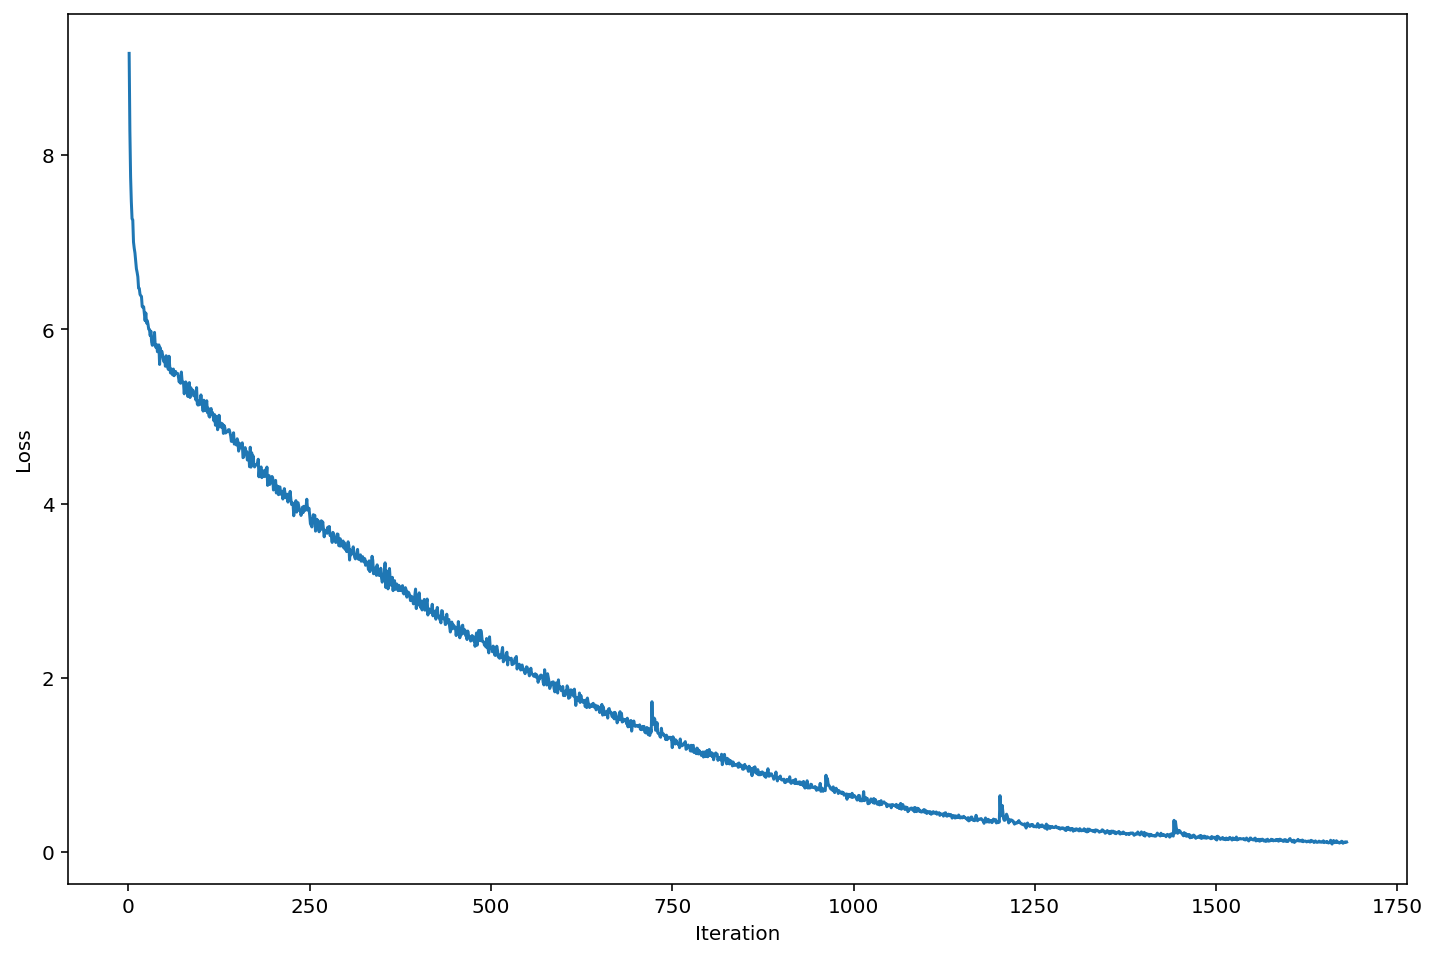

finished 280 epochs - Loss 0.110402412712574


In [167]:
show_training_graph()
print("finished", epochs, "epochs - Loss", losses[-1])
# torch.save(model, DATA_SAVE_PATH+"model.pt")

## Test Model

In [170]:
# model = torch.load(DATA_SAVE_PATH+"model_pitch_4-14.pt")
# model._sample_next = TransformerModel._sample_next.__get__(model, TransformerModel)  # override instance's method if I change it later
# model.generate = MultiCriterionModel.generate.__get__(model, MultiCriterionModel)

In [173]:
# Sample from the model 
# show_example(model.generate(40, 0.05, start="i"))
# show_example(model.generate(200, (.15, .5), start=("I6", 1.5)))
play(model.generate(100, (.25, .25), start=("I", .5)))  # if unable to show notation
# show_example(model.generate(100, (.05, .25)))
# play(model.generate(100, (0.05, 0.5)))

In [165]:
def embedding_diff(embeddings, c1, c2) -> float:
    """
    Returns the Euclidean distance between two embeddings
    """
    # square root of the sum of squares of element-wise differences
    return sum((embeddings[chord_to_num[c1]] - embeddings[chord_to_num[c2]])**2)**(1/2).item()

In [ ]:
print(embedding_diff(model.embed_chord.weight, "V64", "V"))